# 2020 Covid dataset analysed


## Part 1 - Feature Engineering 

In [102]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
import matplotlib.pyplot as plt

In [103]:
list_of_df= []
for (root, dirs, files) in os.walk(os.path.join(os.getcwd(), "county_data")):
    for file in files:
        if file[-4:] == ".csv": 
            df = pd.read_csv(os.path.join(root, file))
            df = df.dropna()
            if len(df):
                name = df["areaName"][5]
                df = df[::-1].reset_index(drop=True)
                y_values = pd.Series(df["newCasesBySpecimenDate"]/df["newVirusTestsBySpecimenDate"])
                for i in range(len(df)):
                        if df["newVirusTestsBySpecimenDate"][i]==0:
                            y_values.loc[i]=0
                list_of_df.append((name,y_values))

In [109]:
from warnings import simplefilter
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def pipeline(model, county, verbose=0):

    def make_lags(ts, lags, lead_time=1):
        return pd.concat(
            {
                f'y_lag_{i}': ts.shift(i)
                for i in range(lead_time, lags + lead_time)
            },
            axis=1)

    # 50 days of lag features
    y = county.copy()*1000 # Scaling up the values in order to not get zero mse
    X = make_lags(y, lags=50).fillna(0.0)

    def make_multistep_target(ts, steps):
        return pd.concat(
            {f'y_step_{i + 1}': ts.shift(-i)
            for i in range(steps)},
            axis=1)

    # 30 days forecast
    y = make_multistep_target(y, steps=30).dropna()

    # Shifting has created indexes that don't match. Only keep times for
    # which we have both targets and features.
    y, X = y.align(X, join='inner', axis=0)

    # Create splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    model.fit(X_train, y_train)

    y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
    y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

    if verbose:
        train_mse = mean_squared_error(y_train, y_fit, squared=False)
        test_mse = mean_squared_error(y_test, y_pred, squared=False)
        print((f"Train MSE: {train_mse:.2f}\n" f"Test MSE: {test_mse:.2f}"))

    return model

In [ ]:
model = LinearRegression()
for i in range(len(list_of_df)):
    model = pipeline(model, list_of_df[i][1])

past_values = 50
def get_data(n):
    values=list(list_of_df[n][1])
    X = []
    y = []
    for i in range(len(values)-past_values):
        X.append(values[i:i+past_values])
        y.append(values[i+past_values])
    X = np.array(X)
    y = np.array(y)
    return X, y

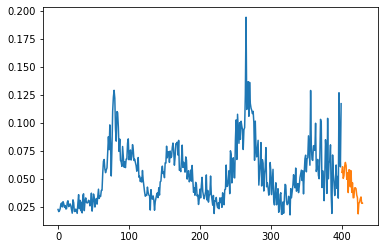

In [136]:
X, y = get_data(106)
# X = X[:-50]
# y = y[:-50]
plt.plot(y[-400:])

shift = 0

x_axis_future = np.arange(400-30*shift, 400-30*(shift-1))
if shift: y_future = model.predict(X[-1-shift:-shift]*1000)/1000
else: y_future = model.predict(X[-1:]*1000)/1000
plt.plot(x_axis_future, y_future[0])
if shift == 0: y = np.append(y, y_future)

In [138]:
import pickle
with open("model", 'wb') as f:
    pickle.dump(model, f)